In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def imshow(src, windowName='show', close=True):
    cv2.imshow(windowName, src)
    cv2.waitKey(0)
    if close:
        cv2.destroyAllWindows()

In [4]:
img_ori = cv2.imread('car.png')
# imshow(img_ori, 'show')
'''
channel = BGR
height = height
width = width
'''
height, width, channel = img_ori.shape
print(height, width, channel)

376 408 3


In [5]:
# Convert Image to grayscale
img_gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
# imshow(img_gray)

In [6]:
# Convolution Gaussian Filter
img_blurred = cv2.GaussianBlur(img_gray, ksize = (5,5), sigmaX = 0)
# imshow(img_blurred)


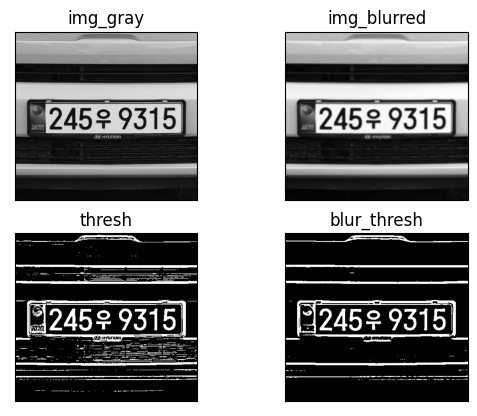

In [7]:
# 기존의 Threshold는 그림자와 같은 명암비를 고려하지 않은 반면, adaptiveThreshold는 주변 음영을 고려하여(Gaussian) 이진화한다.
img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19, # 3이상의 홀수
    C = 9 # 명암 세부조정
)

img_thresh = cv2.adaptiveThreshold(
    img_gray,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19, # 3이상의 홀수
    C = 9
)

titles = ['img_gray', 'img_blurred', 'thresh', 'blur_thresh']
images = [img_gray, img_blurred, img_thresh, img_blur_thresh]

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [23]:
contours, _ = cv2.findContours(
    img_blur_thresh,
    mode = cv2.RETR_LIST,
    method = cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype = np.uint8)
# cv2.drawContours(temp_result, contours = contours, contourIdx = -1, color = (0,255,0))
# imshow(temp_result, 'temp_Result')

contours_dict = []

for i, contour in enumerate(contours):
    x,y,w,h = cv2.boundingRect(contour)
    contours_dict.append(
        {
            'contour':contour,
            'x':x,
            'y':y,
            'w':w,
            'h':h,
            'cx':x+(w/2),
            'cy':y+(h/2)
        }
    )
    cv2.rectangle(temp_result, pt1 = (x,y), pt2 = (x+w,y+h), color = (255,255,255), thickness=2)

# imshow(temp_result)

In [24]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 0.8

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if area > MIN_AREA and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, (d['x'], d['y']), (d['x'] + d['w'], d['y'] + d['h']), (0, 255, 0))
# imshow(temp_result, 'temp_result')

In [25]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3


def find_chars(contour_list):
    matched_result_idx = []
    for d1 in contour_list:
        matched_contour_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            # print(type(d1['cx']), type(d1['cy']) ,type(d2['cx']), type(d2['cy']))
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))

            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
                    and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
                    and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contour_idx.append(d2['idx'])

        matched_contour_idx.append(d1['idx'])

        if len(matched_contour_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contour_idx)
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contour_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        recursive_contour_list = find_chars(unmatched_contour)

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break
    return matched_result_idx


result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, (d['x'], d['y']), (d['x'] + d['w'], d['y'] + d['h']), (0, 255, 0), thickness=2)

cv2.imshow('contours box', temp_result)
cv2.waitKey(0)


-1

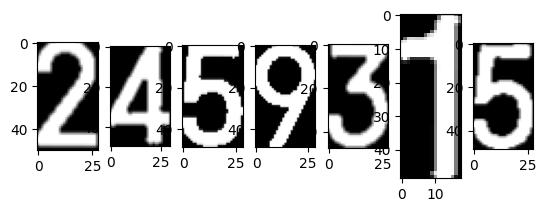

In [26]:
## Rotate plate image
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width), int(plate_height)),
        center=(int(plate_cx), int(plate_cy))
    )

    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[
        0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue

    x = int(plate_cx - plate_width/2)
    y = int(plate_cy - plate_height / 2)
    w = int(plate_width)
    h = int(plate_height)
    # num_idx = 0
    for num_idx, sorted_char in enumerate(sorted_chars):
        number_crop = cv2.getRectSubPix(
            img_rotated,
            patchSize=(int(sorted_char['w']), int(sorted_char['h'])),
            center =(int(sorted_char['cx']), int(sorted_char['cy'])),
        )
        plt.subplot(1, len(sorted_chars), num_idx+1)
        plt.imshow(number_crop, 'gray')
    plt.show()

    img_out = img_ori.copy()
    cv2.rectangle(img_out, (x, y), (x + w, y + h), (0, 255, 0), thickness=2)
    cv2.imshow('test', img_cropped)
    cv2.imshow('orig', img_out)
    cv2.waitKey(0)